In [3]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd

I'm using the Heston stochastic model to generate synthetic trading data for each asset:

https://en.wikipedia.org/wiki/Heston_model

In [53]:
def generate_volatility(V0=0.2, xi=0.15, theta=0.2, kappa=0.1, N=5000, dt=1/365):
    V = np.empty(N)
    V[0] = V0
    for i in range(1, N):
        dw_v = np.sqrt(dt) * np.random.normal()
        sigma = V[i-1] + kappa * (theta - V[i-1]) * dt + xi * np.sqrt(V[i-1]) * dw_v
        V[i] = sigma
    return V

def generate_prices(vola_values, S0=100, mu=0.1, dt=1/365,
           volume=True, mu_volume=4, sigma_volume=1, N=5000):
    S = np.empty(N)
    S[0] = S0
    for i in range(1, N):
        dw_s = np.sqrt(dt) * np.random.normal()
        s = S[i-1] * np.exp((mu - 0.5 * vola_values[i]) * dt + np.sqrt(vola_values[i]) * dw_s)
        S[i] = s
    if volume:
        return S, np.random.lognormal(mu_volume, sigma_volume, len(S))
    return S


In [8]:
def k_means(data, k):
    # data: np-array of vectors (points), shape (n_vectors, vector_dim)
    # k: amount of clusters

    # data size: (n_points, vector_dim)

    center_indices = np.random.randint(0, len(data), size=(1,k)) # (1, k)
    centers = np.array([data[i] for i in center_indices]).reshape((k, data.shape[1])) # (k, vector_dim)
    
    clusters = [[] for _ in range(k)] # (k, n_vectors_to_cluster, vector_dim)
    
    while True:
        new_clusters = clusters
        """
        for every point: determine dist to every cluster
        categorize points based on dist (take smallest)
        redetermine clusters
        """

        labels = [] # length n_vectors

        # determine clusters
        for vector in data:
            # vector: (1, vector_dim)

            # distances for vector to every cluster vector
            # (1, k)

            distances = np.array([np.linalg.norm(vector - core) for core in centers])
            idx = np.argmin(distances)
            new_clusters[idx].append(vector) # list of length k
            labels.append(int(idx))

        if new_clusters == clusters:
            return clusters, centers, labels

        # determine new centers
        for k_idx, cluster in enumerate(clusters):
            # cluster: list of vectors
            avg_vector = np.zeros(data.shape[1])
            for vec in cluster:
                # vec: (vector_dim)
                avg_vector += vec
            avg_vector /= len(cluster)
            centers[k_idx,:] = avg_vector

In [58]:
N = 5 # number of assets in portfolio
M = 3 # number of regimes (states)
T = 5000 # amount of timestamps

# initialization of A
regime_to_regime_prob = 0.9
A = np.diag([regime_to_regime_prob for _ in range(N)])
other_vals = (1 - regime_to_regime_prob) / (N - 1)

# make sure all rows of A sum to 1
for i in range(A.shape[0]):
    if i==0:
        A[0, 1:] = other_vals
    elif i==N - 1:
        A[N - 1, :N - 1] = other_vals
    else:
        A[i, :i] = other_vals
        A[i, i + 1:] = other_vals

regime = np.random.randint(0, M)
regime_seq = np.empty(T)
for i in range(T):
    x = np.random.uniform()
    for r in range(M):
        if A[regime, r] < x:
            # choose regime r as next
            regime = r
            regime_seq[i] = r
            continue

print(regime_seq)



[2. 2. 2. ... 2. 2. 2.]


In [70]:
xi_values = [0.1, 0.12, 0.2] # volatility of volatility
kappa_values = [0.05, 0.05, 0.05] # mean reversion rate
theta_values = [0.12, 0.15, 0.2] # mean volatility

final_prices = np.empty((T, N))

t = 0
S0 = np.full(N, 100)
V0 = np.full(N, 0.15)
while t < T:
    print(regime_seq[35:41])
    print('regime seq t:', regime_seq[t])
    print('regime seq tp:', regime_seq[tp])
    print('t and tp:', t, tp)
    tp = t
    while tp < T:
        if regime_seq[tp] != regime_seq[t]:
            break
        tp += 1

    # both are shape (n-t, N)
    print('n-t:', tp-t)
    vola_values = np.array([generate_volatility(N=tp-t, V0=V0[j]) for j in range(N)]).T
    price_values = np.array([generate_prices(vola_values[:, j], N=tp-t, S0=S0[j], volume=False) for j in range(N)]).T
    S0 = price_values[-1, :]
    V0 = vola_values[-1, :]
    print('price values:', price_values)
    print(price_values.shape)
    final_prices[t:tp, :] = price_values
    t = tp

print(final_prices)


[2.00000000e+000 2.00000000e+000 2.00000000e+000 3.74102222e-306
 2.00000000e+000 2.00000000e+000]
regime seq t: 2.0
regime seq tp: nan
t and tp: 0 101
n-t: 38
price values: [[100.         100.         100.         100.         100.        ]
 [ 98.62538596 101.21653274  98.4576409   97.57404932  97.04661566]
 [ 96.79907929  97.50042482 100.71716843 101.43417016  97.80486127]
 [ 99.07108049  99.43171235 102.76180695 102.13361835  96.05848185]
 [ 95.06961493 101.91742621 100.97500931  98.06814233  94.80147228]
 [ 96.37255679  97.44117893 102.22949715  98.0867685   96.28883261]
 [ 99.30661688 102.16183474 102.22923195  97.59225173  98.66789811]
 [ 94.5935397  104.42209709 101.25879118  96.57123072  97.05780147]
 [ 94.95640567 101.59547056  97.97804353  96.97805052 101.37014852]
 [ 93.6359822  100.40826613  99.14274027  96.13389741 101.65192553]
 [ 92.61902067  97.83414076 102.69489973  99.20201869 104.54131311]
 [ 90.9780962   97.13195342  99.58203133 101.88449583 105.29607566]
 [ 93.0576

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
from scipy.special import logsumexp
from scipy.stats import multivariate_normal

def forward(loga, logb, T, M, logpi):
    logalpha = np.empty((T, M))
    for i in range(M):
        logalpha[0, i] = logpi[i] + logb[0, i]
    for t in range(1, T):
        for j in range(M):
            logterms = [loga[i, j] + logalpha[t - 1, i] for i in range(M)]
            logalpha[t, j] = logsumexp(logterms) + logb[t, j]
        
    return logalpha

def backward(loga, logb, T, M):
    logbeta = np.empty((T, M))
    logbeta[T - 1, :] = 0
    for t in range(T - 2, -1, -1):
        for i in range(M):
            logterms = [loga[i, j] + logb[t + 1, i] + logbeta[t + 1, j] for j in range(M)]
            logbeta[t, i] = logsumexp(logterms)
            
    return logbeta

def compute_gamma(logalpha, logbeta, T, M):
    loggamma = np.empty((T, M))
    for t in range(T):
        for i in range(M):
            loggamma[t, i] = logalpha[t, i] + logbeta[t, i] - logsumexp([
                logalpha[t, j] + logbeta[t, j] for j in range(M)
            ])

    return loggamma

def compute_xi(logalpha, logbeta, loga, logb, T, M):
    xi = np.empty((T, M, M))
    for t in range(T - 1):
        for i in range(M):
            for j in range(M):
                logterms = []
                for k in range(M):
                    for l in range(M):
                        logterms.append(
                            logalpha[t, k] + loga[k, l] + logb[t + 1, l] + logbeta[t + 1, l]
                        )
                xi[t, i, j] = (
                    logalpha[t, i] + loga[i, j] + logb[t + 1, j] + logbeta[t + 1, j]
                    - logsumexp(logterms)
                )
    return xi

def compute_a(loggamma, logxi, T, M):
    loga = np.empty((M, M))
    for i in range(M):
        for j in range(M):
            loga[i, j] = (
                logsumexp([logxi[t, i, j] for t in range(T - 1)])
                - logsumexp([loggamma[t, i] for t in range(T - 1)])
            )
    return loga

def compute_b(mus, Sigmas, dataset, T, M):
    """
    mus: M x N mean returns (over time) per regime and asset
    Sigmas: M x N x N the covariance matrix per regime
    dataset: T x N matrix of returns

    returns: logB, T x M, where logB[t,k] = log p(r_t | s_t = k)
    """

    logb = np.empty((T, M))
    for t in range(T):
        for k in range(M):
            if np.isnan(dataset[t, :]).any() or np.isnan(mus[k, :]).any() or np.isnan(Sigmas[k, :, :]).any():
                print('NAN VALUES:')
                print(dataset[t, :])
                print()
                print(mus[k, :])
                print()
                print(Sigmas[k, :, :])
                raise AssertionError()
            logb[t, k] = multivariate_normal.logpdf(dataset[t, :], mus[k, :], Sigmas[k, :, :])
    return logb

def compute_mus_sigmas(loggamma, dataset, T, M, N, eps=1e-04):
    mus = np.empty((M, N))
    Sigmas = np.empty((M, N, N))
    for m in range(M):
        exp_gammas = np.empty(T)

        # compute mus
        exp_gammas = np.exp(loggamma[:, m])
        den = exp_gammas.sum()
        if den < eps:
            # state got no responsibility -> reinitialize it
            mus[m, :] = np.mean(dataset, axis=0) + np.random.normal(0, 0.01, size=N)
            Sigmas[m, :, :] = np.cov(dataset.T) + eps * np.eye(N)
            continue
        
        mus[m, :] = np.sum(exp_gammas[:, None] * dataset, axis=0) / den

        # compute Sigmas
        diffs = dataset - mus[m, :]
        Sigmas[m, :, :] = (diffs.T @ (diffs * exp_gammas[:, None])) / den

        # stabilize
        Sigmas[m, :, :] = (Sigmas[m, :, :] + Sigmas[m, :, :].T) / 2
        Sigmas[m, :, :] += eps * np.eye(N)

    return mus, Sigmas

    

                    0         1         2         3         4
2010-01-02  -0.000525 -0.008035 -0.011648  0.011403 -0.011285
2010-01-03   0.020606 -0.012614  0.007755 -0.003315 -0.031076
2010-01-04   0.029086 -0.019319  0.009205  0.000390 -0.022770
2010-01-05   0.046295 -0.015913  0.017323 -0.018387 -0.031553
2010-01-06   0.039164 -0.005756  0.015788 -0.019713 -0.029019
...               ...       ...       ...       ...       ...
2024-11-26  11.377500  0.520884  4.362415  1.858090  1.462459
2024-11-27  11.555859  0.529298  4.306441  1.886554  1.489034
2024-11-28  11.619582  0.562144  4.345584  1.899902  1.490987
2024-11-29  11.670911  0.534933  4.400472  1.912005  1.483197
2024-11-30  11.851355  0.540751  4.436333  1.912165  1.487086

[5447 rows x 5 columns]


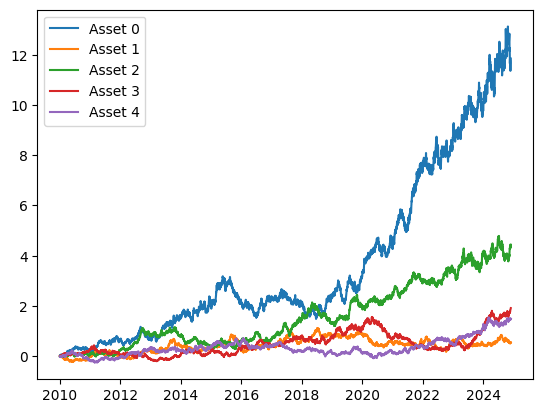

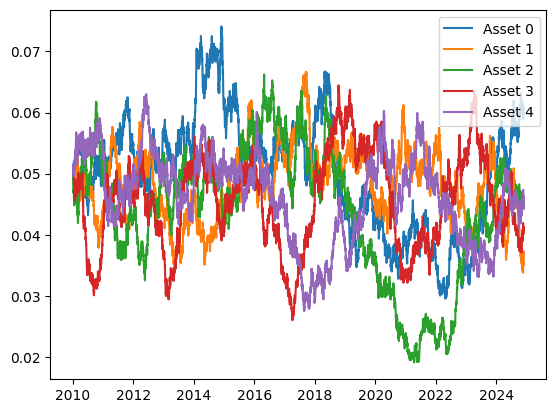

In [ ]:
import matplotlib.pyplot as plt



returns = []
volatilities = []

data = multi_heston(N)
for dataset in data:
    returns.append(dataset["price"].pct_change().values.tolist())
    volatilities.append(dataset["volatility"].values.tolist())

returns = pd.DataFrame(np.array(returns).T[1:, :], index=data[0].index[1:], columns=list(range(N)))
cum_returns = pd.DataFrame((1 + returns).cumprod(axis=0) - 1, index=data[0].index[1:], columns=list(range(N)))
volatilities = pd.DataFrame(np.array(volatilities).T[1:, :], index=data[0].index[1:], columns=list(range(N)))
print(cum_returns)

T = returns.shape[0] # amount of timestamps

fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
for i in range(N):
    ax.plot(cum_returns.index, cum_returns[i], label=f"Asset {i}")
    ax2.plot(volatilities.index, volatilities[i], label=f"Asset {i}")

ax.legend()
ax2.legend()
plt.show()

In [ ]:


clusters, mus, _ = k_means(returns.values, M)
# mus: shape M x N
# clusters: shape M x (num_vectors_in_cluster) x N
Sigmas = np.empty((M, N, N))
for m in range(M):
    cluster = np.array(clusters[m])
    Sigmas[m, :, :] = np.cov(cluster, rowvar=False)

pi = np.full(M, 1 / M)


To compare attempt performance and compare the estimated values to the "real" ones, we can calculate the "true" market regimes, here defined as periods of varying volatility. Because our trading data is simulated, we have direct access to the volatility measures we used to directly compute the price levels.

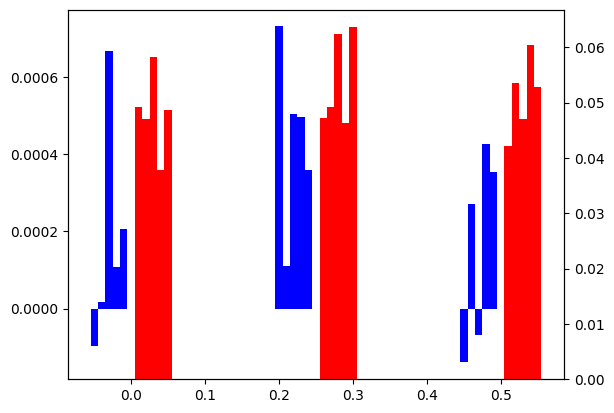

In [26]:
# true values
clusters, centra, true_regimes = k_means(volatilities.values, M)
true_regimes = np.array(true_regimes)

# plot volatility and returns per regime
returns_per_regime_asset = np.empty((M, N))
vola_per_regime_asset = centra # shape (M, N)

width = 1 / (2 * M * N) - 0.01
offsets = (np.arange(M) - (M - 1) / 2) * width * 0.5
offsets[:M//2] -= 0.02
offsets[M//2:] += 0.02

x = np.arange(M)

to_plot = np.empty((M, 2 * N))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

indices = np.arange(M)
offsets = (indices - (M - 1) / 2) * width
gap = 0.01
for regime_idx in range(M):
    returns_matrix = returns.values[regime_idx == true_regimes, :] # all returns in regime m, shape (something, N)
    returns_per_regime_asset[regime_idx, :] = returns_matrix.mean(axis=0) # shape (N,)
    
    c = regime_idx / (M + 1)
    xvalues1 = [c - i*gap for i in range(1, 1+N)]
    xvalues2 = [c + i*gap for i in range(1, 1+N)]

    ax1.bar(xvalues1, returns_per_regime_asset[regime_idx, :], width=gap, color='blue')
    ax2.bar(xvalues2, vola_per_regime_asset[regime_idx, :], width=gap, color='red')

plt.show()


    


    



In [ ]:



# construct true parameters
A_true = np.zeros((M, M))
for t in range(1, len(true_regimes)):
    i = true_regimes[t-1]
    j = true_regimes[t]
    A_true[i, j] += 1

# normalize rows
A_true = (A_true.T / A_true.sum(axis=1)).T

mu_true = np.zeros((M, N))
Sigma_true = np.zeros((M, N, N))

for m in range(M):
    regime_returns = returns.values[true_regimes == m, :] # all returns in regime m
    mu_true[m] = regime_returns.mean(axis=0)
    Sigma_true[m] = np.cov(regime_returns, rowvar=False)

print('A true:', A_true)
print('mu_true:', mu_true)
print('sigma_true:', Sigma_true)

(1541, 5)
(2557, 5)
(1349, 5)
A true: [[0.98767034 0.00973394 0.00259572]
 [0.00547517 0.98631208 0.00821275]
 [0.00296736 0.0148368  0.98219585]]
mu_true: [[ 3.69705368e-04  4.18457486e-04 -3.19080097e-04 -1.08079699e-04
   2.96985224e-04]
 [ 3.83668262e-04  8.51159204e-05  5.97716987e-04  1.34266298e-04
   1.05036587e-04]
 [ 7.83288844e-05  7.42896094e-04  9.12645395e-04  3.45332116e-04
   3.50721452e-04]]
sigma_true: [[[ 1.32887308e-04  1.54489617e-06 -1.09924673e-06  5.69518106e-07
    1.06341555e-07]
  [ 1.54489617e-06  1.44599340e-04  1.48048852e-06 -4.98918283e-06
   -1.86339976e-06]
  [-1.09924673e-06  1.48048852e-06  1.36744416e-04  1.73507977e-06
   -2.36781402e-06]
  [ 5.69518106e-07 -4.98918283e-06  1.73507977e-06  1.50736695e-04
    6.07840010e-07]
  [ 1.06341555e-07 -1.86339976e-06 -2.36781402e-06  6.07840010e-07
    1.45320314e-04]]

 [[ 9.83328692e-05 -6.11793449e-07 -1.59799354e-06 -1.08409972e-06
   -1.34704092e-06]
  [-6.11793449e-07  1.34372660e-04 -1.18679049e-06 -

Here we run the actual algorithm by using the functions defined previously.

In [204]:
n_attempts = 5

A_std_noise = 0.05
pi_std_noise = 0.05
mus_std_noise = 0.02
Sigmas_std_noise = 0.02

A_guesses = []
B_guesses = []
pi_guesses = []
log_ll_guesses = []

for _ in range(n_attempts):
    prev_ll = 0
    ll = 1.0

    # add small noise to initialized values (for A, pi, mus and Sigmas)

    # modify A
    A_diag_val = (A[0, 0] + np.random.normal(0, A_std_noise)).clip(0.01, 0.99)
    A = np.diag([A_diag_val for _ in range(N)])
    other_vals = (1 - A_diag_val) / (N - 1)
    for i in range(A.shape[0]):
        if i==0:
            A[0, 1:] = other_vals
        elif i==N - 1:
            A[N - 1, :N - 1] = other_vals
        else:
            A[i, :i] = other_vals
            A[i, i + 1:] = other_vals

    # modify pi
    pi += np.random.normal(0, pi_std_noise)
    pi /= pi.sum()

    # modify mus
    mus += np.random.normal(0, mus_std_noise, size=mus.shape)



    # modify Sigmas
    for m in range(M):
        print(Sigmas[m, :, :])
        Sigmas[m, :, :] += Sigmas_std_noise * np.eye(N)


    loga = np.log(A)
    logpi = np.log(pi)
    logb = compute_b(mus, Sigmas, returns.values, T, M)

    ll_tol = 0.02

    while abs(prev_ll - ll) > ll_tol:
        prev_ll = ll

        # E step
        logalpha = forward(loga, logb, T, M, logpi)
        logbeta = backward(loga, logb, T, M)
        loggamma = compute_gamma(logalpha, logbeta, T, M)
        logxi = compute_xi(logalpha, logbeta, loga, logb, T, M)

        # M step
        loga = compute_a(loggamma, logxi, T, M)
        mus, Sigmas = compute_mus_sigmas(loggamma, returns.values, T, M, N)
        logb = compute_b(mus, Sigmas, returns.values, T, M)
        logpi = loggamma[0, :]

        log_ll = logsumexp([logalpha[-1, i] for i in range(M)])
        print('log likelyhood:', log_ll)

    print('estimated params:')
    a = np.exp(loga)
    b = np.exp(logb)
    pi = np.exp(logpi)

    a /= a.sum(axis=1, keepdims=True)
    b /= b.sum(axis=1, keepdims=True)
    pi /= pi.sum()

    A_guesses.append(a)
    B_guesses.append(b)
    pi_guesses.append(pi)
    log_ll_guesses.append(log_ll)

    print('a:'); print(a)
    print('b:'); print(b)
    print('pi:'); print(pi)

best_idx = np.argmax(log_ll_guesses)
print('best log ll:', log_ll_guesses[best_idx])
print('corresponding a:', A_guesses[best_idx])
print('corresponding b:', B_guesses[best_idx])



[[ 8.58337127e-05 -1.16982104e-06 -1.26266759e-05 -1.35564167e-05
   2.14098993e-05]
 [-1.16982104e-06  1.37895237e-04  1.53384042e-08  3.50152129e-06
  -3.53906839e-06]
 [-1.26266759e-05  1.53384042e-08  1.20370491e-04  3.35003892e-06
   4.00913060e-06]
 [-1.35564167e-05  3.50152129e-06  3.35003892e-06  1.27881323e-04
   2.24935996e-05]
 [ 2.14098993e-05 -3.53906839e-06  4.00913060e-06  2.24935996e-05
   1.11014709e-04]]
[[ 7.99811800e-05 -3.78457953e-06 -1.76729431e-05  1.62710095e-06
   2.16521210e-05]
 [-3.78457953e-06  1.33892626e-04 -3.55547413e-07  1.17415063e-05
  -5.86867903e-06]
 [-1.76729431e-05 -3.55547413e-07  1.16150341e-04  1.44404725e-05
   2.89157082e-06]
 [ 1.62710095e-06  1.17415063e-05  1.44404725e-05  8.87941036e-05
   4.94120041e-05]
 [ 2.16521210e-05 -5.86867903e-06  2.89157082e-06  4.94120041e-05
   9.23460148e-05]]
[[ 6.44160028e-05 -1.79506994e-06 -3.06464689e-05  1.14679927e-05
   1.69714669e-05]
 [-1.79506994e-06  1.36508288e-04 -3.04825019e-06  1.29399535e-